In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from pretty_midi import PrettyMIDI
import midi_utils as mu
from midi_frame import MidiFrame
# from midi_live_synthesizer import MidiLiveSynthesizer
import scales

In [2]:
# with open("tmp.mid", "r") as f:
#     m = mido.MidiFile(file=f)
    

In [3]:

MIDI_FOLDER = "MIDI_Files/"

# filename = "KCP_Major_1.mid"
# filename = "Under-The-Sea.mid"
# filename = "Wii Channels - Mii Channel.mid"
# filename = "mii_channel_reexported.mid"
# filename = "test_piano.mid"
# filename = "chpn-p1.mid"
# filename = "HesaPirate.mid"
# filename = "Sonic the Hedgehog - Green Hill Zone.mid"
# filename = "toto-africa.mid"
# filename = "vivconct.mid"
filename = "take_on_me_aha.mid"
# filename = "Never-Gonna-Give-You-Up-3.mid"
# filename = "darude-sandstorm.mid"
m = mido.MidiFile(filename=MIDI_FOLDER + filename)
mf = MidiFrame(m, info_type="dispatched")
print(mf)

current_tick = 0
for x in mido.merge_tracks(m.tracks):
    current_tick += x.time
print(current_tick)

current_time = 0
for x in m:
    current_time += x.time
print(current_time)
    

Info type: dispatched
Filename: MIDI_Files/take_on_me_aha.mid
Midi type: 1
Track count: 12
Music track count: 8
Ticks per beat: 96
Length: 224.87758753125752
Channel 01:
	Message count/channel: 1 (1405)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, program_change
	Related Track names: Slap Bass 2
Channel 02:
	Message count/channel: 2 (863)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, program_change
	Related Track names: Elec Guitar 1
Channel 03:
	Message count/channel: 3 (755)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, program_change
	Related Track names: String Sect 3
Channel 04:
	Message count/channel: 4 (741)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, program_change
	Related Track names: Doctor Solo
Channel 05:
	Message count/channel: 5 (688)
	Meta Message count: 0
	Used Message types: control_change, pitchwheel, note_on, program_change
	

None


C:\Users\maxim\COM418-2022-CMProject\midi_utils.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_release"].iloc[mapping] =  time_conv.to_time(df["ticks_release"][mapping])
C:\Users\maxim\COM418-2022-CMProject\midi_utils.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bartime_release"].iloc[mapping] = bartime_conv.to_bartime(df["ticks_release"][mapping])


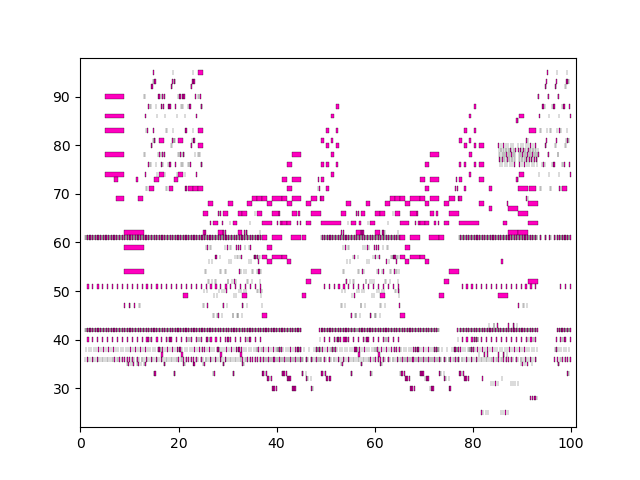

In [4]:
print(mf.playing_track_frame)
mf.make_playing_track_frame([i for i in range(16)])

mu.plot_music(mf.playing_track_frame.get_sub_dataframe(0, 100), 
              metric="bartime",
              chroma_plot=False)


In [5]:
mf.track_frames[7].track

MidiTrack([
  Message('program_change', channel=9, program=0, time=0),
  Message('control_change', channel=9, control=7, value=125, time=0),
  Message('note_on', channel=9, note=36, velocity=127, time=355),
  Message('note_on', channel=9, note=61, velocity=127, time=0),
  Message('note_on', channel=9, note=42, velocity=127, time=1),
  Message('note_on', channel=9, note=61, velocity=0, time=23),
  Message('note_on', channel=9, note=36, velocity=0, time=0),
  Message('note_on', channel=9, note=42, velocity=0, time=1),
  Message('note_on', channel=9, note=61, velocity=127, time=23),
  Message('note_on', channel=9, note=42, velocity=127, time=0),
  Message('note_on', channel=9, note=42, velocity=0, time=20),
  Message('note_on', channel=9, note=61, velocity=0, time=3),
  Message('note_on', channel=9, note=38, velocity=127, time=26),
  Message('note_on', channel=9, note=61, velocity=127, time=0),
  Message('note_on', channel=9, note=42, velocity=127, time=0),
  Message('note_on', channel=9,

In [6]:


suggestions = mf.playing_track_frame.suggest_scale(
    start=0,
    end=4,
    weighted=False,
    normalize_accuracy=True,
    threshold=0.9,
    general_scale_subset=scales.create_general_scale_subset(note_counts=[7])
    # general_scale_subset=[scales.scale(3753),scales.scale(2741)]
    # general_scale_subset=[scales.scale(2741)]
    )

# for scale, accuracy in suggestions:
#     print(scale, ":", f"{int(accuracy*100)}%")
# scale = suggestions[0][0]
# for s in scale.rotated_scales():
#     print(s, s.chromas_name)

for gs in scales.ALL_GENERAL_ROTZERO_SCALES:
    scale_list = gs.scale_in(1).rotated_scales()
    common_set = set(scale_list[0].chromas)
    for s in scale_list[1:]:
        other_set = set(s.chromas)
        if common_set != other_set:
            print(scale_list[0].chromas, "vs", s)
            print("\t", common_set)
            print("\t", other_set)


In [7]:
%timeit -r 4 -n 300 suggestions = mf.playing_track_frame.suggest_scale(start=0, end=100, weighted=False, normalize_accuracy=True, threshold=-1)

1.8 ms ± 39.6 µs per loop (mean ± std. dev. of 4 runs, 300 loops each)
